<h1><span style="color: red; font-family: Lucida Handwriting">Validação de Modelos</span></h1>
<img src="https://opencadd.com.br/wp-content/uploads/2021/02/machine-redimensionado.jpg" width="300" height="300", align="left">

In [362]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_validate, KFold, StratifiedKFold, GroupKFold, StratifiedShuffleSplit
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import randint
import graphviz
import plotly.express as px
import numpy as np
import pandas as pd
import seaborn as sns
import time

In [2]:


uri = "https://gist.githubusercontent.com/guilhermesilveira/e99a526b2e7ccc6c3b70f53db43a87d2/raw/1605fc74aa778066bf2e6695e24d53cf65f2f447/machine-learning-carros-simulacao.csv"

dados = pd.read_csv(uri).drop(columns=["Unnamed: 0"], axis=1)
dados.head()


,preco,vendido,idade_do_modelo,km_por_ano
0,30941.02,1,18,35085.22134
1,40557.96,1,20,12622.05362
2,89627.50,0,12,11440.79806
3,95276.14,0,3,43167.32682
4,117384.68,1,4,12770.11290


In [3]:
x = dados.drop('vendido', axis=1)
y = dados['vendido']

<h2><span style="color: red;">Cross Validation SEM aleatoriedade</span></h2>

In [5]:
def imprime_resultados(results):
    media = results['test_score'].mean()
    dp = results['test_score'].std()
    print(f'''Média: {media:.2%}
Acurácia cross validation com cv 10 = [{media - 2*dp:.2%} , {media + 2*dp:.2%}]''')

In [6]:

SEED = 300
np.random.seed(SEED)
modelo = DecisionTreeClassifier(max_depth=2, random_state=SEED)
results = cross_validate(modelo, x, y, cv=10, return_train_score=False)
imprime_resultados(results)



Média: 75.78%
Acurácia cross validation com cv 10 = [74.24% , 77.32%]


<h2><span style="color: red;">Cross Validation COM aleatoriedade</span></h2>

In [7]:
SEED = 300
np.random.seed(SEED)
modelo = DecisionTreeClassifier(max_depth=2, random_state=SEED)
cv = KFold(10, shuffle=True)
results = cross_validate(modelo, x, y, cv=cv, return_train_score=False)
imprime_resultados(results)


Média: 75.78%
Acurácia cross validation com cv 10 = [71.87% , 79.69%]


<h2><span style="color: red;">Simular situação de azar SEM shuffle </span></h2>

In [8]:
dados_azar = dados.sort_values('vendido', ascending=True)
x_azar = dados_azar.drop(columns='vendido')
y_azar = dados_azar['vendido']

In [9]:
modelo = DecisionTreeClassifier(max_depth=2, random_state=SEED)
cv = KFold(10)
results = cross_validate(modelo, x_azar, y_azar, cv=cv, return_train_score=False)
imprime_resultados(results)


Média: 57.84%
Acurácia cross validation com cv 10 = [34.29% , 81.39%]


<h2><span style="color: red">Simular situação de azar COM shuffle </span></h2>

In [10]:
modelo = DecisionTreeClassifier(max_depth=2, random_state=SEED)
cv = KFold(10, shuffle=True)
results = cross_validate(modelo, x_azar, y_azar, cv=cv, return_train_score=False)
imprime_resultados(results)

Média: 75.78%
Acurácia cross validation com cv 10 = [72.64% , 78.92%]


<h2><span style="color: red;">Simular situação de azar COM shuffle com Stratified</span></h2>

In [11]:
modelo = DecisionTreeClassifier(max_depth=2, random_state=SEED)
cv = StratifiedKFold(10, shuffle=True)
results = cross_validate(modelo, x_azar, y_azar, cv=cv, return_train_score=False)
imprime_resultados(results)

Média: 75.78%
Acurácia cross validation com cv 10 = [72.92% , 78.64%]


<h2 style="color: red">Agrupar dados por modelo de carro usando o GroupKFold</h2>

In [12]:
#Adicionando a coluna Modelo do carro
np.random.seed(SEED)
dados['modelo'] = dados.idade_do_modelo + np.random.randint(-2,3,size=10000) +2
dados.head()

,preco,vendido,idade_do_modelo,km_por_ano,modelo
0,30941.02,1,18,35085.22134,19
1,40557.96,1,20,12622.05362,21
2,89627.50,0,12,11440.79806,14
3,95276.14,0,3,43167.32682,5
4,117384.68,1,4,12770.11290,5


In [13]:
modelo = DecisionTreeClassifier(max_depth=2, random_state=SEED)
cv = GroupKFold(10)
results = cross_validate(modelo, x_azar, y_azar, cv=cv, groups=dados.modelo, return_train_score=False)
imprime_resultados(results)

Média: 75.78%
Acurácia cross validation com cv 10 = [73.10% , 78.46%]


<h2 style="color: red">Validação cruzada com StandardScaler</h2>

In [14]:
#Separar o teste do treino
x_treino, x_teste, y_treino, y_teste = train_test_split(x, y, stratify=y, test_size=0.3)


In [15]:
scale = StandardScaler()
x_treino_escalado = scale.fit_transform(x_treino)
x_teste_escalado = scale.fit_transform(x_teste)
x_azar_escalado = scale.fit_transform(x_azar)

In [16]:
# NÃO É CORRETO USAR O STANDARDSCALER NA BASE DE DADOS APENAS UMA VEZ, 
# ELE DEVE SER FEITO PARA CADA AGRUPAMENTO DO GROUPKFOLD, PARA ISSO
# DEVE SER FEITO ATRAVÉS DE UM PIPELINE

modelo = SVC()
cv = GroupKFold(10)
results = cross_validate(modelo, x_azar_escalado, y_azar, cv=cv, groups=dados.modelo, return_train_score=False)
imprime_resultados(results)

Média: 76.69%
Acurácia cross validation com cv 10 = [74.43% , 78.96%]


<h2 style="color: red">Validação cruzada com StandardScale usando um Pipeline</h2>

In [17]:
svc = SVC()
scaler = StandardScaler()
pipeline = Pipeline([('transformador', scaler), ('estimador_svc',svc)])
cv = GroupKFold(10)
results = cross_validate(pipeline, x_azar, y_azar, cv=cv, groups=dados.modelo, return_train_score=False)
imprime_resultados(results)

Média: 76.68%
Acurácia cross validation com cv 10 = [74.32% , 79.05%]


<h2 style="color: red">Otimização do modelo com alteração dos parâmetros 1 dimensão</h2>

In [67]:
def dtreeclassifier(max_depth):
    modelo = DecisionTreeClassifier(max_depth=max_depth, random_state=SEED)
    cv = GroupKFold(10)
    results = cross_validate(modelo, x_azar, y_azar, cv=cv, groups=dados.modelo, return_train_score=True)
    media = results['test_score'].mean()
    treino = results['train_score'].mean()
    return [max_depth, media, treino]
    


In [76]:
tabela = [dtreeclassifier(i) for i in range(1,32)]
df = pd.DataFrame(tabela, columns=['max_depth', 'teste', 'treino'])



In [114]:
# df[['teste', 'treino']] = df[['teste', 'treino']].applymap(lambda x: f'{x:.2%}')
fig = px.line(data_frame=df, x='max_depth', y=['teste', 'treino'], title='<b>Validando o max_depth</b>')
fig.update_layout(title_x = 0.5)
fig.add_annotation(text=f'Ponto <b style="color:red">Ótimo</b> com {df[df.teste == df.teste.max()].max_depth.values[0]} max_depth<br>Acurácia = <b>{df.teste.max():.2%}',
                    y=df['teste'].max(),
                    x=df[df['teste'] == df['teste'].max()]['max_depth'].values[0],
                    showarrow=True,
                    arrowhead=1)
fig.update_yaxes(title='Acurácia')
fig

<h2 style="color: red">Otimização do modelo com alteração dos parâmetros 2 dimensões</h2>

In [140]:
def dtreeclassifier2p(max_depth, min_samples_leaf):
    modelo = DecisionTreeClassifier(max_depth=max_depth, min_samples_leaf=min_samples_leaf)
    cv = GroupKFold(10)
    results = cross_validate(modelo, x_azar, y_azar, cv=cv, groups=dados.modelo, return_train_score=True)
    media = results['test_score'].mean()
    treino = results['train_score'].mean()
    return [max_depth, min_samples_leaf,media, treino]
    
def busca(lista):
    resultados = []
    for i in range(1,32):
        for j in lista:
            tabela = dtreeclassifier2p(max_depth=i, min_samples_leaf=j)
            resultados.append(tabela)
    resultados = pd.DataFrame(resultados, columns=['max_depth', 'min_samples_leaf', 'teste', 'treino'])
    return resultados
    

In [118]:
resultados = busca([32, 64, 128, 256])


,max_depth,min_samples_leaf,teste,treino
0,1,32,0.757828,0.757911
1,1,64,0.757828,0.757911
2,1,128,0.757828,0.757911
3,1,256,0.757828,0.757911
4,2,32,0.757828,0.757911
...,...,...,...,...
11,3,256,0.787042,0.787512
10,3,128,0.787042,0.787512
15,4,256,0.787042,0.787512
9,3,64,0.787042,0.787512


In [120]:
resultados.corr()

,max_depth,min_samples_leaf,teste,treino
max_depth,1.000000e+00,-2.819789e-16,0.010811,0.556437
min_samples_leaf,-2.819789e-16,1.000000e+00,0.385404,-0.394814
teste,1.081076e-02,3.854042e-01,1.000000,0.211624
treino,5.564367e-01,-3.948138e-01,0.211624,1.000000


In [160]:
corr = resultados.corr()
corr = corr.applymap(lambda x: round(x,3))
px.imshow(corr, text_auto=True, width=800, height=800)

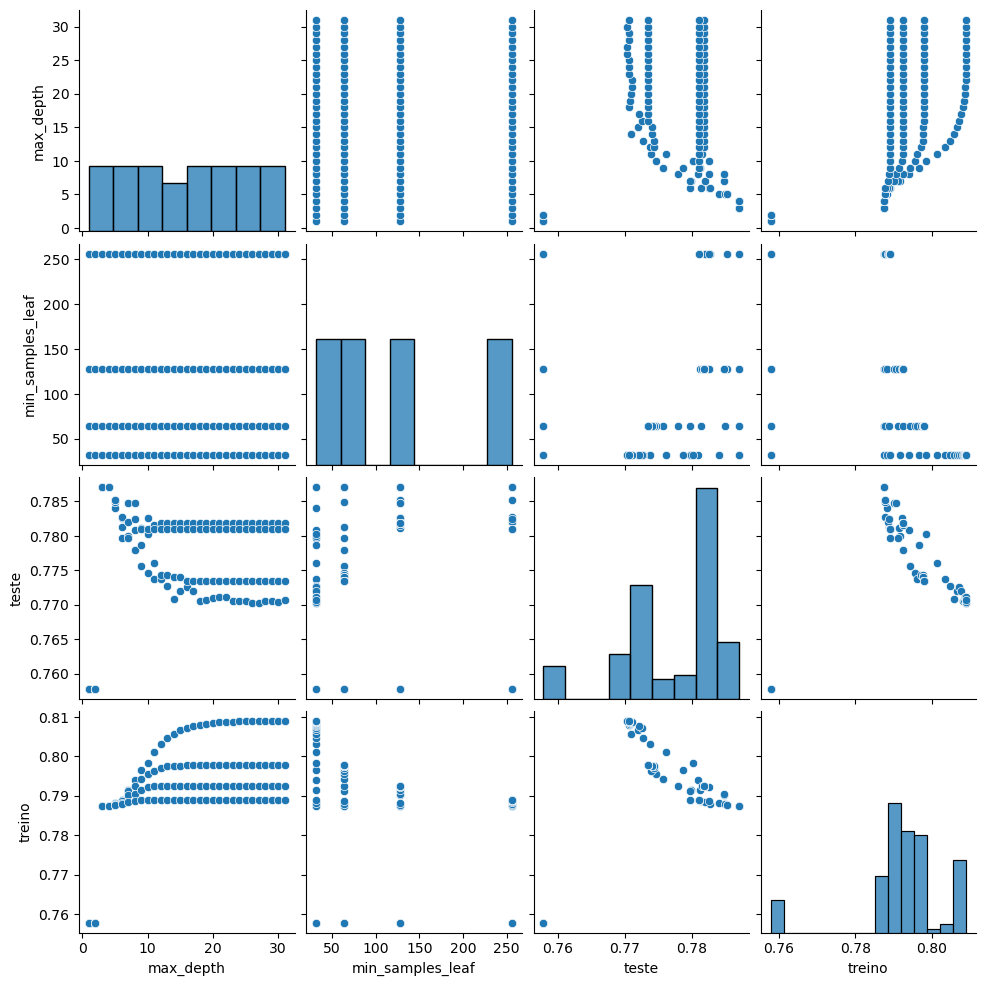

In [141]:
sns.pairplot(data=resultados)

In [142]:
resultados2 = busca([128, 192, 256, 512])

In [159]:
corr = resultados2.corr()
corr = corr.applymap(lambda x: round(x,3))
px.imshow(corr, text_auto=True, width=800, height=800)

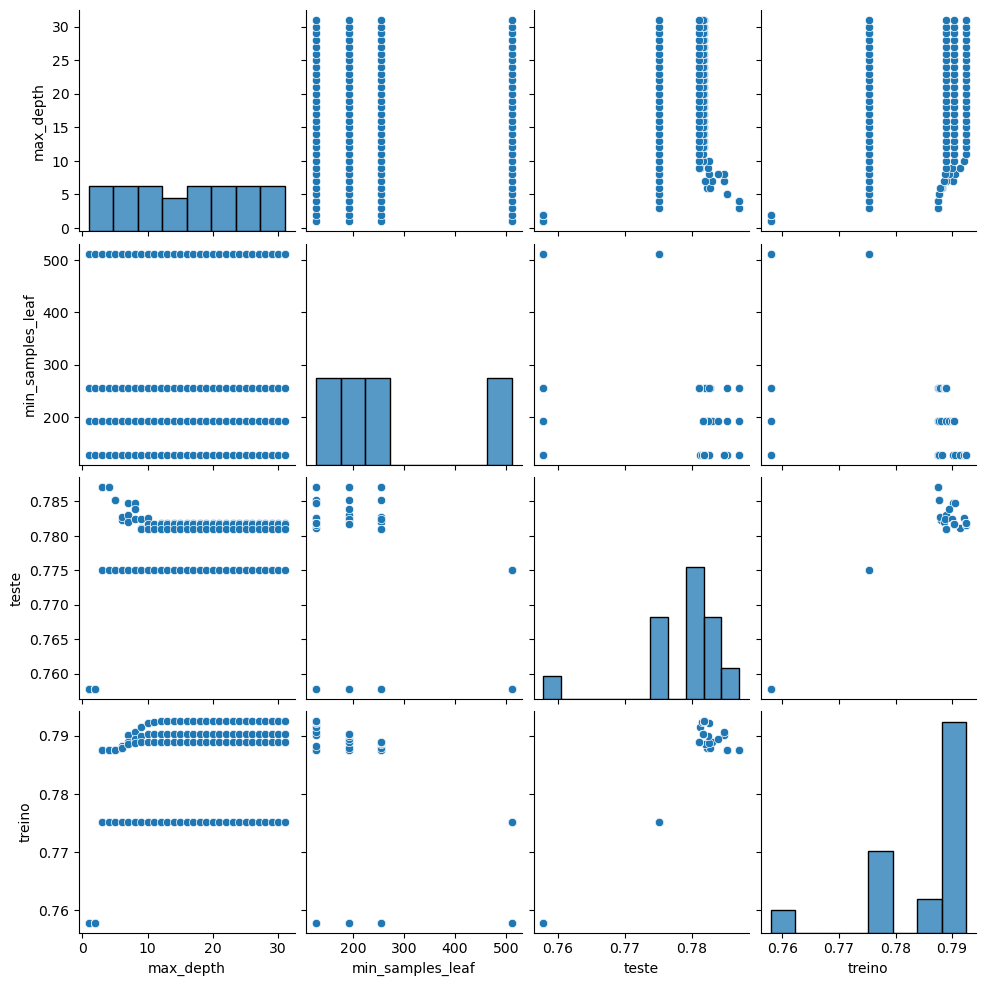

In [153]:
sns.pairplot(data=resultados2)

<h3>Conclusões</h3>
<h4>Configuração: min_samples_leaf [32, 64, 128, 256] e max_depth 1 à 31</h4>
<p>Há uma correlação forte positiva com a acurácia média do treino e o max_depth, contudo há uma correlação fraca negativa com o max_depth e a acurácia média do testo, isso pode ser explicado pelo overfit, ou seja, o modelo viciou com os dados de treino.</p>
<p>Nota-se uma correlação fraca positica entre os min_samples_leaf e a acurácia do teste, e não foi observado uma correlação entre o min_samples_leaf e o max_depth</p>
<h4>Configuração: min_samples_leaf [128, 192, 256, 512] e max_depth 1 à 31</h4>
<p>A correlação entre o max_depth e a acurácia média dos dados de treino se tornou uma correlação fraca positiva, enquanto a correlação entre o min_samples_leaf e a acurácia média dos dados de teste se tornaram uma correlação forte negativa, logo nessa faixa não é interessante aumentar o parâmetro min_samples_leaf</p>
<h3>Melhor configuração</h3>
<p>max_depth = 3 ou 4
<br>min_samples_leaf = 32, 64, 128 ou 256</p>

<h2 style="color: red">Otimização do modelo com alteração dos parâmetros 3 ou mais dimensões</h2>

In [211]:
def dtreeclassifier3p(max_depth, min_samples_leaf, min_samples_split):
    modelo = DecisionTreeClassifier(max_depth=max_depth, 
                                    min_samples_leaf=min_samples_leaf, 
                                    min_samples_split=min_samples_split)
    cv = GroupKFold(10)
    results = cross_validate(modelo, x_azar, y_azar, cv=cv, groups=dados.modelo, return_train_score=True)
    teste = results['test_score'].mean()
    fit_time = results['fit_time'].mean()
    score_time = results['score_time'].mean()
    treino = results['train_score'].mean()
    return [max_depth, min_samples_leaf, min_samples_split, fit_time, score_time, teste, treino]
    
def busca3(lista):
    resultados = []
    for max_depth in range(1,16):
        for min_samples_leaf in [32, 64, 128, 256]:
            for min_samples_split in lista:
                tabela = dtreeclassifier3p(max_depth=max_depth, 
                                           min_samples_leaf=min_samples_leaf, 
                                           min_samples_split=min_samples_split)
                resultados.append(tabela)
    resultados = pd.DataFrame(resultados, columns=['max_depth', 'min_samples_leaf', 
                                                   'min_samples_split' ,'teste', 'treino',
                                                  'fit_time', 'score_time'])
    return resultados

In [212]:
resultados = busca3([32, 64, 128, 256])

In [216]:
resultados.columns = ['max_depth', 'min_samples_leaf', 'min_samples_split' , 'fit_time', 'score_time','teste', 'treino']
resultados.sort_values('teste', ascending=False).head(10)

,max_depth,min_samples_leaf,min_samples_split,fit_time,score_time,teste,treino
58,4,128,128,0.009696,0.001000,0.787042,0.787512
38,3,64,128,0.007798,0.001301,0.787042,0.787512
55,4,64,256,0.009296,0.001399,0.787042,0.787512
54,4,64,128,0.009698,0.001198,0.787042,0.787512
53,4,64,64,0.010195,0.001399,0.787042,0.787512
52,4,64,32,0.009298,0.001298,0.787042,0.787512
32,3,32,32,0.008100,0.001099,0.787042,0.787512
33,3,32,64,0.007995,0.001100,0.787042,0.787512
34,3,32,128,0.008098,0.001299,0.787042,0.787512
35,3,32,256,0.007993,0.001100,0.787042,0.787512


In [218]:
corr = resultados.corr()
corr = corr.applymap(lambda x: round(x,3))
px.imshow(corr, text_auto=True, width=800, height=800)

<h2 style="color: red">Otimização do modelo com o GridSearchCV</h2>

In [231]:
SEED = 331
np.random.seed(SEED)
parametros = {
    'max_depth': [3,5],
    'min_samples_split': [32, 64, 128, 256],
    'min_samples_leaf': [32, 64, 128, 256],
    'criterion': ['gini', 'entropy']
}
busca = GridSearchCV(DecisionTreeClassifier(), parametros, cv = GroupKFold(n_splits=10))
busca.fit(x_azar, y_azar, groups=dados.modelo)

GridSearchCV(cv=GroupKFold(n_splits=10), estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'], 'max_depth': [3, 5],
                         'min_samples_leaf': [32, 64, 128, 256],
                         'min_samples_split': [32, 64, 128, 256]})

In [249]:
results = pd.DataFrame(busca.cv_results_)

print(f'''melhores parametros: {busca.best_params_}
melhor score: {busca.best_score_:.2%}
''')

melhores parametros: {'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 32, 'min_samples_split': 32}
melhor score: 78.70%



<b>testando o melhor modelo

In [239]:
melhor_modelo = busca.best_estimator_
predicoes = melhor_modelo.predict(x_azar)
acuracy = accuracy_score(predicoes, y_azar)
print(f'Acurácia: {acuracy:.2%}')

Acurácia: 78.75%


<h2 style="color: red">Como ter uma estimativa sem esse vício nos dados que eu já vi?</h2>
<h3>No caso de cross validation com busca de hiper parâmetros, fazemos uma nova validação cruzada.
<br>Chama-se nested cross validation</h3>

In [251]:
scores = cross_val_score(busca, x_azar, y_azar, cv=GroupKFold(n_splits=10), groups=dados.modelo)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning:


10 fits failed out of a total of 10.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py", line 891, in fit
    self._run_search(evaluate_candidates)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py", line 1392, in _run_search
    evaluate_candidates(ParameterGrid(self.param

<b style="color: red">A versão atual do pandas tem um bug no GroupKFold, onde não recebe o parametro groups
    <br> Logo teremos que usar o KFold

In [253]:
SEED = 331
np.random.seed(SEED)
parametros = {
    'max_depth': [3,5],
    'min_samples_split': [32, 64, 128, 256],
    'min_samples_leaf': [32, 64, 128, 256],
    'criterion': ['gini', 'entropy']
}
buscakfold = GridSearchCV(DecisionTreeClassifier(), parametros, cv = KFold(n_splits=5, shuffle=True))
buscakfold.fit(x_azar, y_azar)

GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=True),
             estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'], 'max_depth': [3, 5],
                         'min_samples_leaf': [32, 64, 128, 256],
                         'min_samples_split': [32, 64, 128, 256]})

In [272]:

resultado = pd.DataFrame(buscakfold.cv_results_)
filtro = (resultado['params']==buscakfold.best_params_)
dp = resultado[filtro]['std_test_score'].values[0]

print(f'''melhores parametros: {buscakfold.best_params_}
melhor score: {buscakfold.best_score_:.2%} +/- {2*dp:.2%}
''')

melhores parametros: {'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 32, 'min_samples_split': 32}
melhor score: 78.67% +/- 1.06%



In [256]:
scores = cross_val_score(buscakfold, x_azar, y_azar, cv=KFold(n_splits=5, shuffle=True))

In [259]:
print(f'Média Acurácia: {scores.mean():.2%} +/- {2*scores.std():.2%}')

Média Acurácia: 78.68% +/- 2.06%


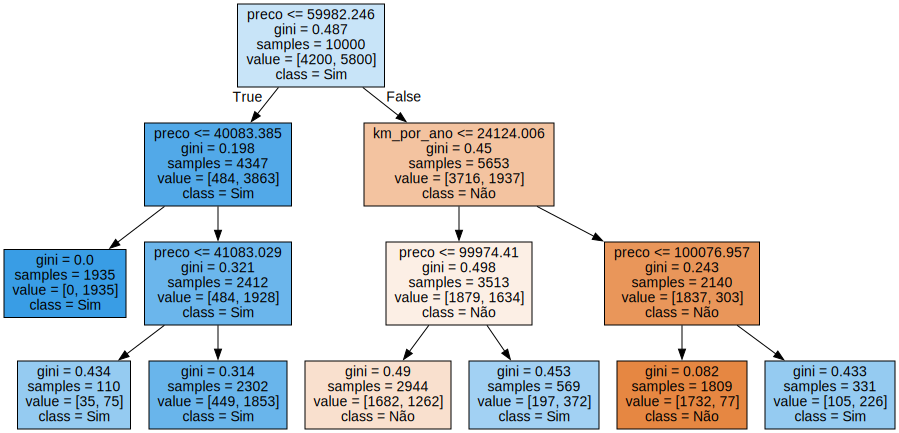

In [260]:
modelokfold = buscakfold.best_estimator_
features = x_azar.columns
dot_data = export_graphviz(modelokfold, 
                           out_file=None, 
                           feature_names=features, 
                           class_names=['Não', 'Sim'],
                          filled=True)
graphviz.Source(dot_data)

<h2 style="color: red">Otimização com exploração aleatória</h2>

In [296]:
SEED = 331
np.random.seed(SEED)
parametros = {
    'max_depth': [3,5,7],
    'min_samples_split': [32, 64, 128, 256],
    'min_samples_leaf': [32, 64, 128, 256],
    'criterion': ['gini', 'entropy']
}
busca_randomized = RandomizedSearchCV(DecisionTreeClassifier(), 
                           parametros,
                            random_state=SEED,
                           n_iter=16,
                           cv = KFold(n_splits=5, shuffle=True))
busca_randomized.fit(x_azar, y_azar, groups=dados.modelo)

RandomizedSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=True),
                   estimator=DecisionTreeClassifier(), n_iter=16,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': [3, 5, 7],
                                        'min_samples_leaf': [32, 64, 128, 256],
                                        'min_samples_split': [32, 64, 128,
                                                              256]},
                   random_state=331)

In [297]:
scores_randomized = cross_val_score(busca_randomized, x_azar, y_azar, cv=KFold(n_splits=5, shuffle=True))
print(f'Média Acurácia: {scores_randomized.mean():.2%} +/- {2*scores_randomized.std():.2%}')

Média Acurácia: 78.67% +/- 0.57%


DecisionTreeClassifier(criterion='entropy', max_depth=3, min_samples_leaf=256,
                       min_samples_split=32)


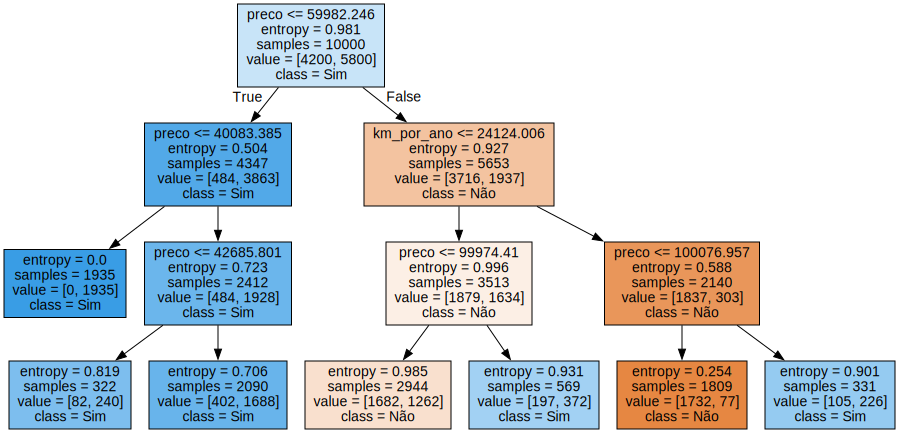

In [300]:
modelo_randomized = busca_randomized.best_estimator_
print(modelo_randomized)
features = x_azar.columns
dot_data = export_graphviz(modelo_randomized, 
                           out_file=None, 
                           feature_names=features, 
                           class_names=['Não', 'Sim'],
                          filled=True)
graphviz.Source(dot_data)

<h2 style="color: red">Customizando o espaço de hiper parâmetros</h2>

In [341]:
SEED = 331
np.random.seed(SEED)
parametros = {
    'max_depth': [3, 5, 10, 15, 20, 30, None],
    'min_samples_split': randint(32, 129),
    'min_samples_leaf': randint(32, 129),
    'criterion': ['gini', 'entropy']
}
busca_randomized_scipy = RandomizedSearchCV(DecisionTreeClassifier(), 
                                            parametros,
                                            random_state=SEED,
                                            n_iter=64,
                                            cv = KFold(n_splits=5, shuffle=True))
busca_randomized_scipy.fit(x_azar, y_azar, groups=dados.modelo)
print('busca completa')

busca completa


In [327]:
scores_randomized_scipy = cross_val_score(busca_randomized_scipy, x_azar, y_azar, cv=KFold(n_splits=5, shuffle=True))
print(f'Média Acurácia: {scores_randomized_scipy.mean():.2%} +/- {2*scores_randomized_scipy.std():.2%}')

Média Acurácia: 78.69% +/- 1.42%


In [347]:
results = pd.DataFrame(busca_randomized_scipy.cv_results_)
results = results.sort_values(['mean_test_score', 'mean_fit_time'], ascending=[False, True])

In [350]:
tela = results[['mean_fit_time', 'mean_test_score', 'std_test_score', 'params']].copy()

tela['mean_fit_time'] = tela['mean_fit_time'].map(lambda x: f'{x:.3f} s')
tela['mean_test_score'] = tela['mean_test_score'].map(lambda x: f'{x:.2%}')
tela['2*std_test_score'] = tela['std_test_score'].map(lambda x: f'+/- ({2*x:.2%})')
tela.drop('std_test_score', axis=1, inplace=True)
tela[['mean_fit_time', 'mean_test_score', '2*std_test_score', 'params']].head()

,mean_fit_time,mean_test_score,2*std_test_score,params
11,0.007 s,78.67%,+/- (1.06%),"{'criterion': 'gini', 'max_depth': 3, 'min_sam..."
22,0.007 s,78.67%,+/- (1.06%),"{'criterion': 'gini', 'max_depth': 3, 'min_sam..."
2,0.007 s,78.67%,+/- (1.06%),"{'criterion': 'gini', 'max_depth': 3, 'min_sam..."
18,0.007 s,78.67%,+/- (1.06%),"{'criterion': 'gini', 'max_depth': 3, 'min_sam..."
33,0.007 s,78.67%,+/- (1.06%),"{'criterion': 'gini', 'max_depth': 3, 'min_sam..."


<h2 style="color: red">Customizando o espaço de hiper parâmetros do RandoForestClassifier</h2>

In [356]:
SEED = 331
np.random.seed(SEED)
parametros = {
    'max_depth': [3, 5, 10, 15, 20, 30, None],
    'min_samples_split': randint(32, 129),
    'min_samples_leaf': randint(32, 129),
    'criterion': ['gini', 'entropy'],
    'bootstrap': [True, False]
}
busca_randomized_RFC = RandomizedSearchCV(RandomForestClassifier(), 
                                            parametros,
                                            random_state=SEED,
                                            n_iter=30,
                                            cv = KFold(n_splits=5, shuffle=True))
busca_randomized_RFC.fit(x_azar, y_azar, groups=dados.modelo)
print('busca completa')

busca completa


In [357]:
scores_randomized_RFC = cross_val_score(busca_randomized_RFC, x_azar, y_azar, cv=KFold(n_splits=5, shuffle=True))
print(f'Média Acurácia: {scores_randomized_RFC.mean():.2%} +/- {2*scores_randomized_RFC.std():.2%}')

Média Acurácia: 78.49% +/- 1.39%


In [360]:
results = pd.DataFrame(busca_randomized_RFC.cv_results_)
results = results.sort_values(['mean_test_score', 'mean_fit_time'], ascending=[False, True])

In [361]:
tela = results[['mean_fit_time', 'mean_test_score', 'std_test_score', 'params']].copy()

tela['mean_fit_time'] = tela['mean_fit_time'].map(lambda x: f'{x:.3f} s')
tela['mean_test_score'] = tela['mean_test_score'].map(lambda x: f'{x:.2%}')
tela['2*std_test_score'] = tela['std_test_score'].map(lambda x: f'+/- ({2*x:.2%})')
tela.drop('std_test_score', axis=1, inplace=True)
tela[['mean_fit_time', 'mean_test_score', '2*std_test_score', 'params']].head()

,mean_fit_time,mean_test_score,2*std_test_score,params
4,0.549 s,78.01%,+/- (0.47%),"{'bootstrap': False, 'criterion': 'gini', 'max..."
0,0.589 s,77.82%,+/- (1.02%),"{'bootstrap': True, 'criterion': 'entropy', 'm..."
10,0.921 s,77.81%,+/- (0.69%),"{'bootstrap': False, 'criterion': 'entropy', '..."
11,0.527 s,77.73%,+/- (0.42%),"{'bootstrap': True, 'criterion': 'gini', 'max_..."
8,0.561 s,77.71%,+/- (0.72%),"{'bootstrap': False, 'criterion': 'gini', 'max..."


<h2 style="color: red">Caso não poder ou não conseguir usar o cross validation</h2>

In [372]:
#treino => 0.6
#teste => 0.2
#validação => 0.2

x_treino, x_validacao, y_treino, y_validacao = train_test_split(x_azar, y_azar, stratify=y_azar, test_size=0.2)


In [395]:
SEED = 331
np.random.seed(SEED)
parametros = {
    'max_depth': randint(3, 11),
    'min_samples_split': randint(32, 129),
    'min_samples_leaf': randint(32, 129),
    'criterion': ['gini', 'entropy'],
    'bootstrap': [True, False]
}

# test_size = 0.2 / 0.8 = 0.25
split = StratifiedShuffleSplit(n_splits=1, test_size=0.25, random_state=SEED)

busca_randomized_RFC_SCV = RandomizedSearchCV(RandomForestClassifier(), 
                                            parametros,
                                            random_state=SEED,
                                            n_iter=64,
                                            cv = split)
busca_randomized_RFC_SCV.fit(x_treino, y_treino)
print('busca completa')

busca completa


In [396]:
scores_randomized_RFC = cross_val_score(busca_randomized_RFC_SCV, x_validacao, y_validacao, cv=split)
print(f'Média Acurácia: {scores_randomized_RFC.mean():.2%} ')

Média Acurácia: 76.20% 


In [397]:
results_SCV = pd.DataFrame(busca_randomized_RFC_SCV.cv_results_)
result_SCVs = results.sort_values(['mean_test_score', 'mean_fit_time'], ascending=[False, True])

In [398]:
tela = results_SCV[['mean_fit_time', 'mean_test_score', 'std_test_score', 'params']].copy()

tela['mean_fit_time'] = tela['mean_fit_time'].map(lambda x: f'{x:.3f} s')
tela['mean_test_score'] = tela['mean_test_score'].map(lambda x: f'{x:.2%}')
tela['2*std_test_score'] = tela['std_test_score'].map(lambda x: f'+/- ({2*x:.2%})')
tela.drop('std_test_score', axis=1, inplace=True)
tela[['mean_fit_time', 'mean_test_score', '2*std_test_score', 'params']].head()

,mean_fit_time,mean_test_score,2*std_test_score,params
0,0.466 s,79.40%,+/- (0.00%),"{'bootstrap': True, 'criterion': 'entropy', 'm..."
1,0.332 s,78.35%,+/- (0.00%),"{'bootstrap': True, 'criterion': 'entropy', 'm..."
2,0.420 s,79.35%,+/- (0.00%),"{'bootstrap': False, 'criterion': 'gini', 'max..."
3,0.374 s,78.20%,+/- (0.00%),"{'bootstrap': True, 'criterion': 'entropy', 'm..."
4,0.371 s,78.25%,+/- (0.00%),"{'bootstrap': False, 'criterion': 'entropy', '..."
